# Predicting Parking Spot Availability in Chicago
Using Deep Learning and LLM Agents

In [3]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost tensorflow langchain openai


In [4]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost tensorflow openai
!pip install langchain langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.5 MB/s eta 0:00:00


In [5]:
!pip install -U langchain langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.6/433.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.9 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.51
    Uninstalling langchain-core-0.3.51:
      Successfully uninstalled langchain-core-0.3.51


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime
import xgboost as xgb


In [7]:
from langchain_openai import OpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

In [10]:
# Upload your CSV files in Colab before running
activities = pd.read_csv('cleaned_activities.csv')
parking = pd.read_csv('cleaned_parking_zones.csv')
weather = pd.read_csv('cleaned_weather.csv')

activities['Event_Date'] = pd.to_datetime(activities['Event_Date'])
weather['Date'] = pd.to_datetime(weather['Date'])


In [11]:
# Extract features from Event Dates
activities['hour'] = activities['Event_Date'].dt.hour
activities['day'] = activities['Event_Date'].dt.day
activities['weekday'] = activities['Event_Date'].dt.weekday
activities['month'] = activities['Event_Date'].dt.month
activities['date'] = activities['Event_Date'].dt.date

# Count events per date
event_density = activities.groupby('date').size().reset_index(name='Event_Count')
event_density['date'] = pd.to_datetime(event_density['date'])

# Merge with weather
merged = pd.merge(weather, event_density, left_on='Date', right_on='date', how='left')
merged['Event_Count'] = merged['Event_Count'].fillna(0)
merged = merged.drop(columns=['date'])


In [12]:
from sklearn.preprocessing import MinMaxScaler

features = ['Temp_Avg', 'Temp_Min', 'Temp_Max', 'Precipitation', 'Snowfall', 'Wind_Speed', 'Pressure', 'Event_Count']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged[features])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length][-1])  # Predict Event_Count
    return np.array(X), np.array(y)

sequence_length = 10
X, y = create_sequences(scaled_data, sequence_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [13]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0059 - val_loss: 3.2081e-05
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3599e-05 - val_loss: 1.4153e-05
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.8687e-05 - val_loss: 1.4839e-05
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6574e-05 - val_loss: 8.2470e-06
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0626e-05 - val_loss: 5.4359e-06
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.2019e-06 - val_loss: 5.2051e-06
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.5230e-06 - val_loss: 3.4583e-06
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.2357e-06 - val_loss: 1.8835e-06
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.5259e-06 - val_loss: 1.5700e-06
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9923e-06 - val_loss: 1.1687e-06
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7777e-06 - val_lo

In [14]:
preds = model.predict(X_test)
mse = mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)

print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MSE: 0.0000
MAE: 0.0006


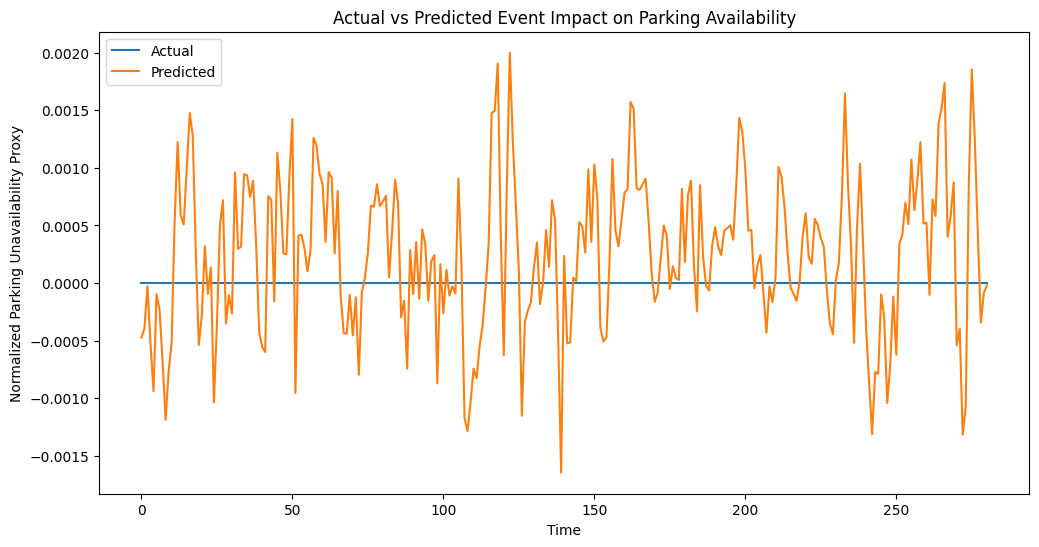

In [15]:
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual')
plt.plot(preds, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Event Impact on Parking Availability')
plt.xlabel('Time')
plt.ylabel('Normalized Parking Unavailability Proxy')
plt.show()


## 🤖 LLM Agent (Hugging Face Transformers - Offline & Free)
This section uses a Hugging Face GPT model to explain parking trends in plain English.

In [16]:
# ✅ Hugging Face LLM Agent (No API Key Needed)
!pip install transformers --quiet

from transformers import pipeline

# Load a small GPT-style model
generator = pipeline("text-generation", model="distilgpt2")

# Function to explain parking trends
def explain_parking_trend(trend: str):
    prompt = f"Explain this parking trend in simple terms: {trend}"
    output = generator(prompt, max_length=50, do_sample=True)[0]['generated_text']
    return output

# Example usage
sample_trend = "Parking availability drops significantly near Wrigley Field on game days."
response = explain_parking_trend(sample_trend)
print("🧠 GPT-style explanation:", response)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🧠 GPT-style explanation: Explain this parking trend in simple terms: Parking availability drops significantly near Wrigley Field on game days.
To learn more, click here.
Photo Credits: Chris Allen
About this site
We are a public service organization that runs public
